# This notebook is for further cleaning of the glider data for plotting

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import glob
import os
import waypoint_distance as wd
%matplotlib widget

# Plotting function

In [2]:
def plot_mission(ds, lat_bounds=None, lon_bounds=None):
    """
    Plot a single glider path over bathymetry for the Calvert Line.

    Parameters:
    - file_path: str, optional, used to extract mission name
    - lon_bounds, lat_bounds: optional bounds for plotting
    """
    
    topo_file=os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')

    # Extract lon/lat
    lons = ds['longitude'].values
    lats = ds['latitude'].values
    time_vals = ds['time'].values
    time_nums = mdates.date2num(time_vals)

    # Auto bounds if not provided
    if lon_bounds is None:
        lon_bounds = [lons.min() - 0.5, lons.max() + 0.5]
    if lat_bounds is None:
        lat_bounds = [lats.min() - 0.5, lats.max() + 0.5]

    # Load topo data
    topo = xr.open_dataset(topo_file)
    topo = topo.sel(
        lon=slice(lon_bounds[0], lon_bounds[1]),
        lat=slice(lat_bounds[0], lat_bounds[1]))

    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(lon_bounds + lat_bounds, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Plot bathymetry
    topo_var = -topo['Band1']
    levels = np.linspace(0, 410, 51)
    contourf = ax.contourf(topo['lon'], topo['lat'], topo_var,
                           levels=levels, cmap=cm.cm.deep, extend='both')
    fig.colorbar(contourf, ax=ax, label='Depth (m)')

    # Add 0 m elevation contour in black
    ax.contour(topo['lon'], topo['lat'], topo_var, levels=[0.5], colors='black', linewidths=1)

    # Plot glider track
    sc = ax.scatter(lons, lats, c=time_nums, cmap='seismic',
                    vmin=time_nums.min(), vmax=time_nums.max(),
                    s=5, transform=ccrs.PlateCarree(), label='Filtered Track')
    cbar = fig.colorbar(sc, ax=ax, orientation='vertical', extend='both')
    cbar.set_label('Date')
    cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Title
    if file_pathway:
        mission_name = os.path.basename(file_pathway).split('_')[0]
        ax.set_title(f'Cleaned Glider Mission Track – {mission_name}', fontsize=14)
    else:
        ax.set_title('Cleaned Glider Mission Track', fontsize=14)

    plt.tight_layout()

# Load topo data
topo_file=os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')
topo = xr.open_dataset(topo_file)

# Define along coordinate system, clean data for plotting

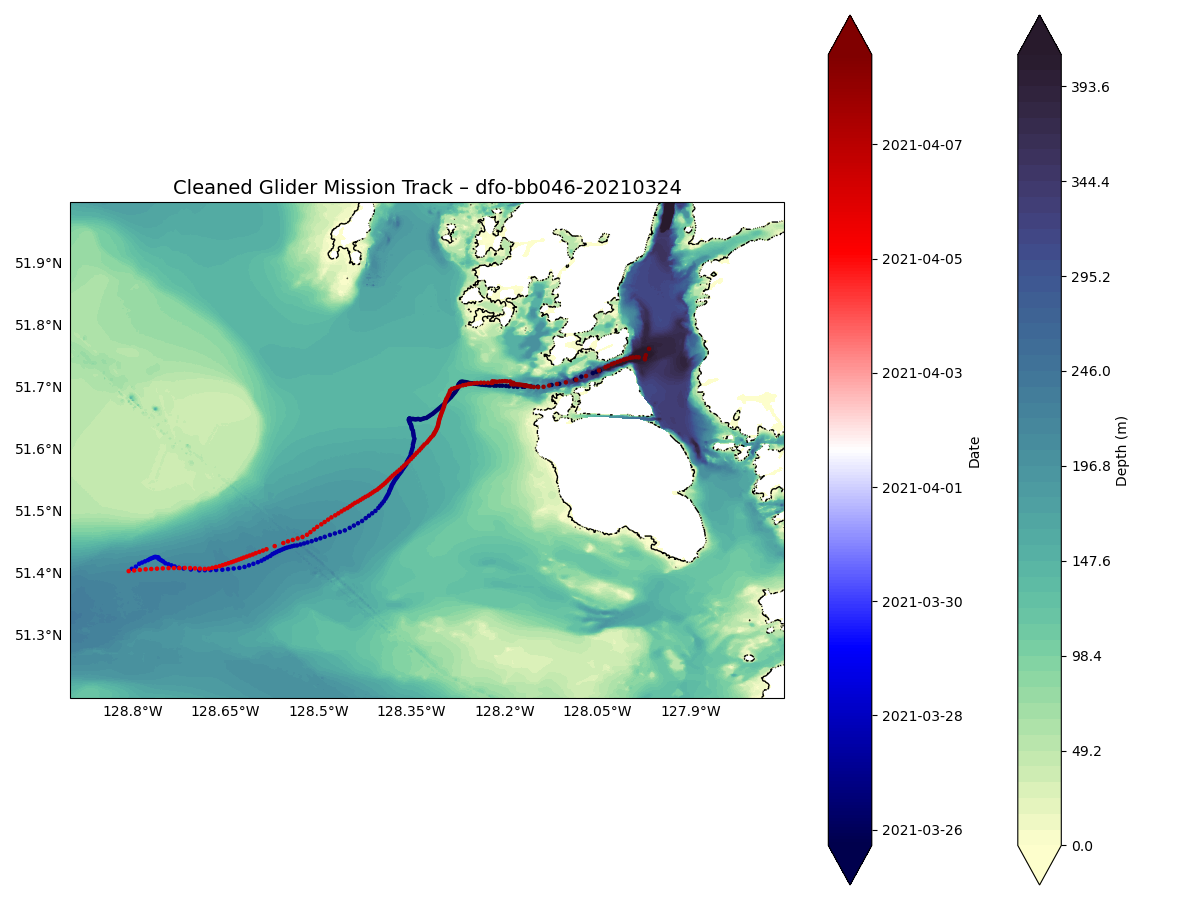

In [3]:
def clean_and_plot_mission(file_pathway, lat_bounds=(51.2, 52), long_bounds=(-128.9, -127.75)):
    """
    Clean and plot a glider mission by separating outbound and return transects,
    removing redundant points, and plotting the results.
    """
    ds = xr.open_dataset(file_pathway)

    # Waypoints
    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    # Distance projection
    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)

    # Add along and across to ds
    ds = ds.assign(along=('time', alongx))
    ds = ds.assign(across=('time', acrossx))

    # Separate ds into out and return transects
    gradient_along = np.gradient(ds['along'])
    zero_indices = np.where(gradient_along == 0)[0]
    # Indices to figure out how the out and return should be separated
    # Requires gradient_along to have zeros in the middle, which are created from the projection function and it's bounds
    start = zero_indices[0]
    end = zero_indices[-1] + 1

    # Creating the masks
    out_mask = np.zeros_like(gradient_along, dtype=bool)
    return_mask = np.zeros_like(gradient_along, dtype=bool)
    out_mask[:start] = gradient_along[:start] > 0
    return_mask[end:] = gradient_along[end:] < 0

    # Defining new ds, one for each part of the trip
    ds_out = ds.sel(time=out_mask)
    ds_return = ds.sel(time=return_mask)

    # Iteratively remove points from glider loops (outbound)
    prev_len = -1
    while prev_len != len(ds_out['time']):
        prev_len = len(ds_out['time'])
        grad = np.gradient(ds_out['along'])
        keep_mask = grad > 0
        ds_out = ds_out.sel(time=keep_mask)

    # Iteratively remove points from glider loops (returnbound)
    prev_len = -1
    while prev_len != len(ds_return['time']):
        prev_len = len(ds_return['time'])
        grad = np.gradient(ds_return['along'])
        keep_mask = grad < 0
        ds_return = ds_return.sel(time=keep_mask)

    # Combine back into ds, plot. Data is now clean, not yet horizontally gridded
    ds = xr.concat([ds_out, ds_return], dim='time')
    plot_mission(ds, lat_bounds = lat_bounds, lon_bounds = long_bounds)
    # plot_mission(ds_out, file_path = '/Users/martinwilliamson/Desktop/dfo-bb046-20210324_grid_delayed.nc',  lat_bounds = lat_bounds, long_bounds = long_bounds)
    # plot_mission(ds_return, file_path = '/Users/martinwilliamson/Desktop/dfo-bb046-20210324_grid_delayed.nc',  lat_bounds = lat_bounds, long_bounds = long_bounds)
    return ds, ds_out, ds_return

# Example usage
if __name__ == "__main__":
    file_pathway = '/Users/martinwilliamson/Desktop/dfo-bb046-20210324_grid_delayed.nc'
    # lat_bounds = (51.2, 52)
    # lon_bounds = (-128.9, -127.75)
    ds, ds_out, ds_return = clean_and_plot_mission(file_pathway)

# Check time gradients, see that the time difference is reasonable over the ds

In [4]:
if __name__ == "__main__":
    # Compute time gradients as timedelta64[ns]
    time_grad_out = np.gradient(ds_out['time'].values.astype('datetime64[ns]'))
    time_grad_return = np.gradient(ds_return['time'].values.astype('datetime64[ns]'))

    # Print raw gradients in seconds
    print(f'Time differences between profiles for the OUT trip (seconds): {time_grad_out.astype("timedelta64[s]")}')
    print(f'Time differences between profiles for the RETURN trip (seconds): {time_grad_return.astype("timedelta64[s]")}')

    # Compute and convert max differences to hours
    max_time_diff_out = np.max(time_grad_out).astype('timedelta64[ns]').astype(np.int64)
    max_time_diff_return = np.max(time_grad_return).astype('timedelta64[ns]').astype(np.int64)

    print(f'Maximum time difference in the OUT trip: {max_time_diff_out / 3.6e12:.2f} hours')
    print(f'Maximum time difference in the RETURN trip: {max_time_diff_return / 3.6e12:.2f} hours')

Time differences between profiles for the OUT trip (seconds): [2139 2638 3448 2696 2323 2211 1817 1667 1060  674  575  780  801  733
  678  676  699  700  814  870  818  819  811  787  782  794  809  813
  796  766  746  757  751  732  785  811  811  842  720  710  881  909
  774  770 1089 1095  778  770  917  921  754  724 1000 1006  728  732
 1053 1073  766  760  931  953  798  788  944  965  818  816 1537 1540
  816  807 1347 1347  808  804 1001 1003  802 1878 1872  790  929  945
  828  826  982  993  842  840 1013 1037  884  870 1041 1079  924  896
 1263 1263  884  888 1046 1050  896  896 1049 1057  908  898 1125 1142
  930  930 1095 1105  936  922 1071 1077  938  948 1123 1137  976  964
 1117 1115  956  958 1107 1121  988  990 1167 1171  986  994 1203 1219
 1050 1058 1204 1194 1048 1058 1283 1307 1104 1098 1263 1263 1090 1084
 1247 1270 1128 1133 1625 1627 1142 1142 1303 1303 1150 1164 1381 1387
 1178 1184 1349 1343 1192 1188 1333 1337 1180 1184 1357 1353 1178 1174
 1359 1359 1170

# Interpolating

In [5]:
def interpolate(ds):
    """
    Interpolate the dataset to a regular grid along the 'along' dimension.
    """
    # Drop duplicates in the 'along' dimension
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)
    
    # Ensure 'along' is a coordinate
    if 'along' not in ds.coords:
        raise ValueError("'along' must be a coordinate in the dataset.")

    # Create a new grid for interpolation
    along_grid = np.arange(ds['along'].min(), ds['along'].max(), 200)  # resolution of 200m

    # Save the original 'time' variable
    original_time = ds['time'].values

    # Swap dimensions and interpolate
    ds_swapped = ds.swap_dims({'time': 'along'})
    ds_interpolated = ds_swapped.interp(along=along_grid)

    # Reassign 'time' to the interpolated dataset
    # Use linear interpolation to estimate time values for the new 'along' grid
    ds_interpolated['time'] = ('along', np.interp(along_grid, ds['along'].values, original_time.astype(float)))

    return ds_interpolated

# Plot Sections #

In [6]:
def plot_section(ds_out, ds_return):
    """
    Plot temperature and potential density sections for both outbound and return transects for out and return transects.
    """
    
    ds_out = ds_out.set_coords('along')
    ds_return = ds_return.set_coords('along')

    # Interpolate the outbound and return datasets
    ds_out = interpolate(ds_out)
    ds_return = interpolate(ds_return)

    for ds, transect_type in zip([ds_out, ds_return], ["Outbound", "Return"]):
        # Interpolate bathymetry at lat/lon positions
        interp_bathy = topo['Band1'].interp(
            lon=xr.DataArray(ds['longitude'].values, dims='time'),
            lat=xr.DataArray(ds['latitude'].values, dims='time'))
        bottom_depths = -interp_bathy
        
        # Extract variables
        along = ds['along'].values
        time = ds['time']
        depth = ds['depth'].values
        temperature = ds['temperature'].values
        pdens = ds['potential_density'].values - 1000  # Sigma-theta

        # ===== Plot Along-Transect Section =====
        fig, ax = plt.subplots(figsize=(12, 6))
        cf = ax.pcolormesh(along, depth, temperature, shading='nearest', cmap=cm.cm.thermal)
        ax.plot(along, bottom_depths, color='black', linewidth=2, label='Bathymetry')

        cf_iso = ax.contour(along, depth, pdens, levels=np.linspace(24, 27, 16),
                            colors='grey', linewidths=0.5, linestyles='-')
        ax.clabel(cf_iso, fmt='%1.2f', fontsize=10)

        ax.set_xlabel('Along-Transect Distance (m)')
        ax.set_ylabel('Depth (m)')
        ax.invert_yaxis()
        ax.set_title(f'Temperature Section ({ds.attrs.get("mission", "Mission")})')
        cf.set_clim(vmin=ds['temperature'].min(), vmax=ds['temperature'].max())
        plt.colorbar(cf, ax=ax, label='Temperature (°C)')
        ax.legend(loc='lower right')
        plt.tight_layout()
        ax.set_ylim(410, 0)
        ax.set_xlim(0, 77000)

        # ===== Plot Time Section =====
        fig, ax = plt.subplots(figsize=(12, 6))
        cf = ax.pcolormesh(time, depth, temperature, shading='nearest', cmap=cm.cm.thermal)
        ax.plot(time, bottom_depths, color='black', linewidth=2, label='Bathymetry')

        cf_iso = ax.contour(time, depth, pdens, levels=np.linspace(24, 27, 16),
                            colors='grey', linewidths=0.5, linestyles='-')
        ax.clabel(cf_iso, fmt='%1.2f', fontsize=10)

        ax.set_xlabel('Time')
        ax.set_ylabel('Depth (m)')
        ax.invert_yaxis()
        ax.set_title(f'Temperature Section (Time) ({ds.attrs.get("mission", "Mission")})')
        plt.colorbar(cf, ax=ax, label='Temperature (°C)')
        ax.legend(loc='lower right')
        plt.tight_layout()
        ax.set_ylim(410, 0)
        # Invert x-axis for return transect in the time plot
        if transect_type == "Return":
            ax.invert_xaxis()

/var/folders/w3/xmmx3z314913xcdb0jf7m8h40000gn/T/ipykernel_3243/640135.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax.pcolormesh(time, depth, temperature, shading='nearest', cmap=cm.cm.thermal)


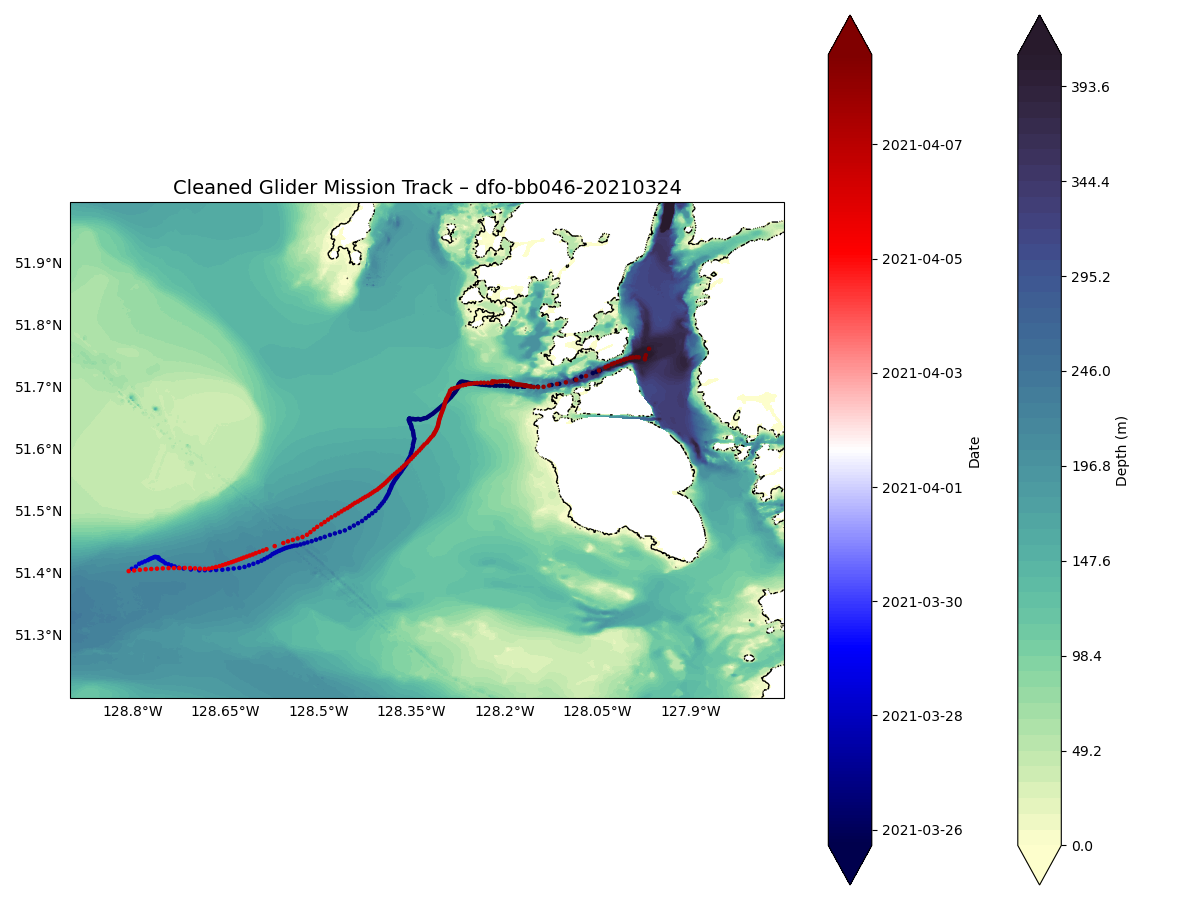

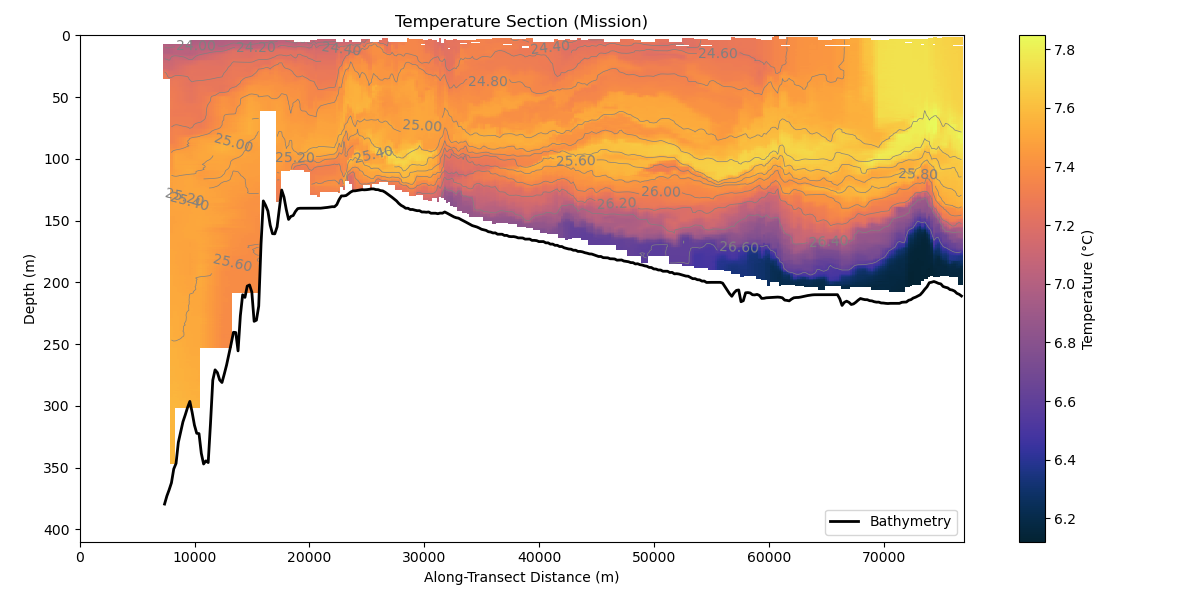

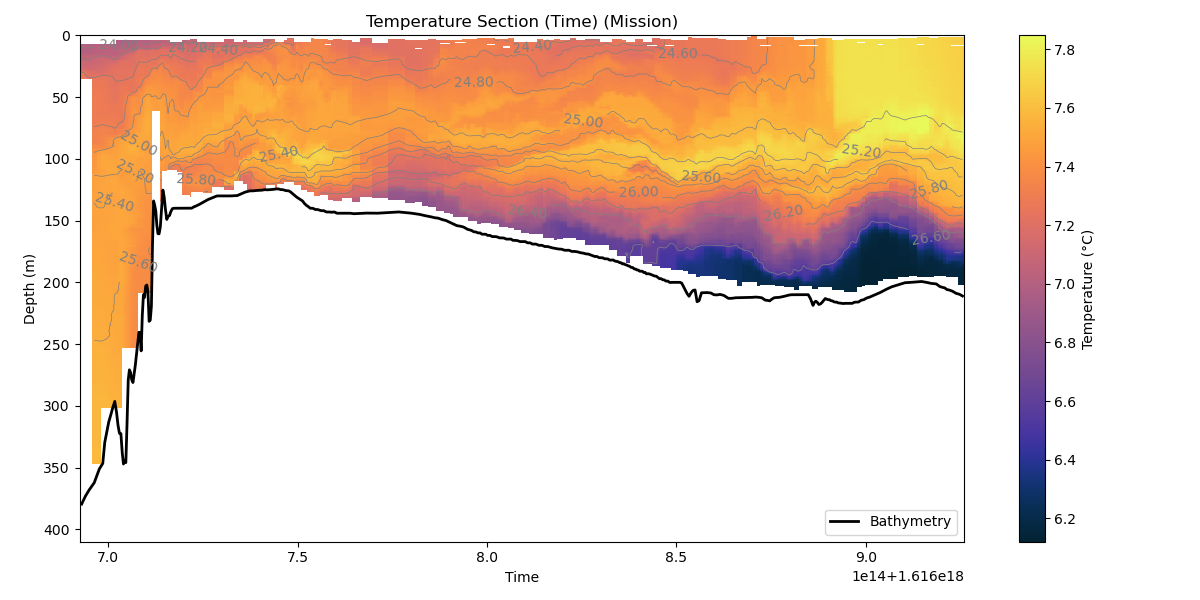

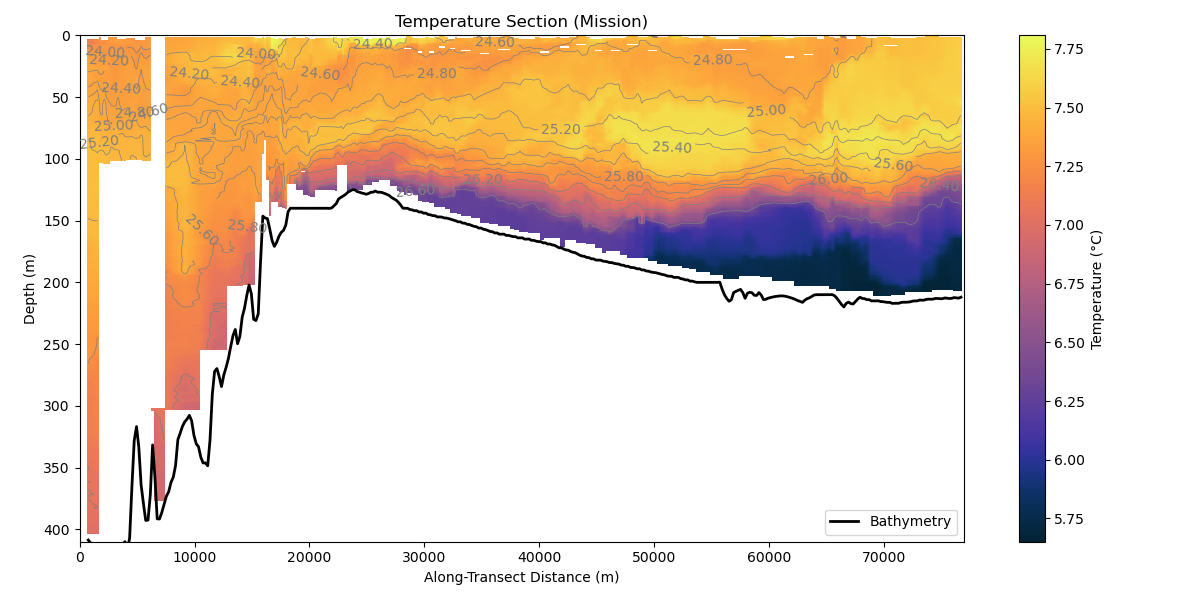

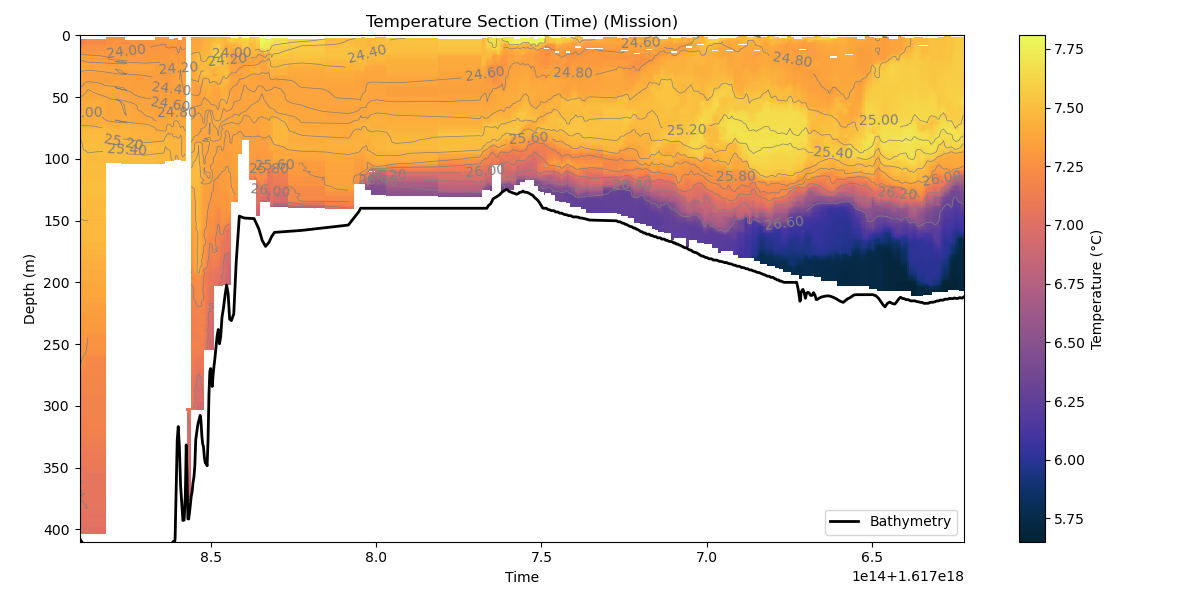

In [7]:
def process_glider_mission(file_pathway, lat_bounds=(51.2, 52), lon_bounds=(-128.9, -127.75)):
    """
    Clean, plot on a map, and plot sections for both outbound and return glider trips.
    Args:
        file_pathway (str): Path to the glider netCDF file.
        lat_bounds (tuple): Latitude bounds for plotting.
        lon_bounds (tuple): Longitude bounds for plotting.
    """
    # Clean and split the mission
    ds, ds_out, ds_return = clean_and_plot_mission(file_pathway, lat_bounds=lat_bounds, long_bounds=lon_bounds)
    # Plot sections for outbound and return
    plot_section(ds_out, ds_return)

# Example usage:
process_glider_mission('/Users/martinwilliamson/Desktop/dfo-bb046-20210324_grid_delayed.nc')

In [8]:
ds

<xarray.Dataset> Size: 64MB
Dimensions:                (time: 404, depth: 1100)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
    profile                (time) float64 3kB 1.0 2.0 3.0 ... 798.0 799.0 800.0
  * time                   (time) datetime64[ns] 3kB 2021-03-25T17:22:41.6728...
    longitude              (time) float64 3kB -128.0 -128.1 ... -128.0 -128.0
    latitude               (time) float64 3kB 51.73 51.73 51.72 ... 51.75 51.76
Data variables: (12/23)
    profile_time_start     (time) datetime64[ns] 3kB 1970-01-01T00:00:51.7280...
    profile_time_end       (time) datetime64[ns] 3kB 1970-01-01T00:00:51.7280...
    heading                (depth, time) float64 4MB nan nan nan ... nan nan nan
    pitch                  (depth, time) float64 4MB nan nan nan ... nan nan nan
    roll                   (depth, time) float64 4MB nan nan nan ... nan nan nan
    conductivity           (depth, time) float64 4MB nan nan nan ... nan nan nan
    ...                     ...
    potential_density      (depth, time) float64 4MB nan nan nan ... nan nan nan
    density                (depth, time) float64 4MB nan nan nan ... nan nan nan
    potential_temperature  (depth, time) float64 4MB nan nan nan ... nan nan nan
    mission_number         (time) int32 2kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    along                  (time) float64 3kB 7.384e+03 7.811e+03 ... 741.9
    across                 (time) float64 3kB 140.9 122.9 ... 287.2 1.135e+03
Attributes: (12/66)
    Conventions:               CF-1.8
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    comment:                   Calvert Island deployment
    contributor_name:          James Pegg, Jody Klymak, Tetjana Ross, Jennife...
    contributor_role:          Lead Technician, Principal Investigator, Co-PI...
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC as part...
    time_coverage_end:         2021-04-08T15:43:55
    time_coverage_start:       2021-03-25T16:56:31
    title:                     dfo-bb046-20210325T1656
    transmission_system:       IRIDIUM
    wmo_id:                    4803918